d #Demand Forecasting

The objective of this notebook is to illustrate how we might generate a large number of fine-grained forecasts at the store-item level in an efficient manner leveraging the distributed computational power of Databricks.  For this exercise, we will make use of an increasingly popular library for demand forecasting, [FBProphet](https://facebook.github.io/prophet/), which we will load into the notebook session associated with a cluster running Databricks 6.0 or higher. Please check out this [blog](https://databricks.com/blog/2020/08/24/profit-driven-retention-management-with-machine-learning.html) post for more details. Please check out this [https://databricks.com/blog/2020/01/27/time-series-forecasting-prophet-spark.html](blog) for more details.

In [0]:
# load fbprophet library
dbutils.library.installPyPI('FBProphet', version='0.5') # find latest version of fbprophet here: https://pypi.org/project/fbprophet/
dbutils.library.installPyPI('holidays','0.9.12') # this line is in response to this issue with fbprophet 0.5: https://github.com/facebook/prophet/issues/1293

dbutils.library.restartPython()

## Examine the Data

For our training dataset, we will make use of 5-years of store-item unit sales data for 50 items across 10 different stores.  This data set is publicly available as part of a past Kaggle competition and can be downloaded [here](https://www.kaggle.com/c/demand-forecasting-kernels-only/data). 

Once downloaded, we can uzip the *train.csv.zip* file and upload the decompressed CSV to */FileStore/tables/demand_forecast/train/* using the file import steps documented [here](https://docs.databricks.com/data/tables.html#create-table-ui). Please note when performing the file import, you don't need to select the *Create Table with UI* or the *Create Table in Notebook* options to complete the import process.

With the dataset accessible within Databricks, we can now explore it in preparation for modeling:

In [0]:
from pyspark.sql.types import *

# structure of the training data set
train_schema = StructType([
  StructField('date', DateType()),
  StructField('store', IntegerType()),
  StructField('item', IntegerType()),
  StructField('sales', IntegerType())
  ])

# read the training file into a dataframe
train = spark.read.csv(
  '/FileStore/tables/train-2.csv', 
  header=True, 
  schema=train_schema
  )

# make the dataframe queriable as a temporary view
train.createOrReplaceTempView('train')

In [0]:
%sql

select count(*) from train

count(1)
913000


When performing demand forecasting, we are often interested in general trends and seasonality.  Let's start our exploration by examing the annual trend in unit sales:

In [0]:
%sql

SELECT
  year(date) as year, 
  sum(sales) as sales
FROM train
GROUP BY year(date)
ORDER BY year;

year,sales
2013,7941243
2014,9135482
2015,9536887
2016,10357160
2017,10733740


It's very clear from the data that there is a generally upward trend in total unit sales across the stores. If we had better knowledge of the markets served by these stores, we might wish to identify whether there is a maximum growth capacity we'd expect to approach over the life of our forecast.  But without that knowledge and by just quickly eyeballing this dataset, it feels safe to assume that if our goal is to make a forecast a few days, months or even a year out, we might expect continued linear growth over that time span.

Now let's examine seasonality.  If we aggregate the data around the individual months in each year, a distinct yearly seasonal pattern is observed which seems to grow in scale with overall growth in sales:

In [0]:
%sql

SELECT 
  TRUNC(date, 'MM') as month,
  SUM(sales) as sales
FROM train
GROUP BY TRUNC(date, 'MM')
ORDER BY month;

month,sales
2013-01-01,454904
2013-02-01,459417
2013-03-01,617382
2013-04-01,682274
2013-05-01,763242
2013-06-01,795597
2013-07-01,855922
2013-08-01,766761
2013-09-01,689907
2013-10-01,656587


Aggregating the data at a weekday level, a pronounced weekly seasonal pattern is observed with a peak on Sunday (weekday 0), a hard drop on Monday (weekday 1) and then a steady pickup over the week heading back to the Sunday high.  This pattern seems to be pretty stable across the five years of observations:

In [0]:
%sql
set spark.sql.legacy.timeParserPolicy = LEGACY;
SELECT
  YEAR(date) as year,
  CAST(DATE_FORMAT(date, 'u') as Integer) % 7 as weekday,
  --CONCAT(DATE_FORMAT(date, 'u'), '-', DATE_FORMAT(date, 'EEEE')) as weekday,
  AVG(sales) as sales
FROM (
  SELECT 
    date,
    SUM(sales) as sales
  FROM train
  GROUP BY date
 ) x
GROUP BY year, CAST(DATE_FORMAT(date, 'u') as Integer) --, CONCAT(DATE_FORMAT(date, 'u'), '-', DATE_FORMAT(date, 'EEEE'))
ORDER BY year, weekday;

year,weekday,sales
2013,0,25788.44230769231
2013,1,17269.69230769231
2013,2,20015.811320754718
2013,3,20150.153846153848
2013,4,21503.19230769231
2013,5,23071.096153846152
2013,6,24532.903846153848
2014,0,29901.0
2014,1,19791.98076923077
2014,2,23179.346153846152


Now that we are oriented to the basic patterns within our data, let's explore how we might build a forecast.

###Build a Forecast

Before attempting to generate forecasts for individual combinations of stores and items, it might be helpful to build a single forecast for no other reason than to orient ourselves to the use of FBProphet.

Our first step is to assemble the historical dataset on which we will train the model:

In [0]:
# query to aggregate data to date (ds) level
sql_statement = '''
  SELECT
    CAST(date as date) as ds,
    sales as y
  FROM train
  WHERE store=1 AND item=1
  ORDER BY ds
  '''

# assemble dataset in Pandas dataframe
history_pd = spark.sql(sql_statement).toPandas()

# drop any missing records
history_pd = history_pd.dropna()

Now, we will import the fbprophet library, but because it can be a bit verbose when in use, we will need to fine-tune the logging settings in our environment:

In [0]:
from fbprophet import Prophet
import logging

# disable informational messages from fbprophet
logging.getLogger('py4j').setLevel(logging.ERROR)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.

Based on our review of the data, it looks like we should set our overall growth pattern to linear and enable the evaluation of weekly and yearly seasonal patterns. We might also wish to set our seasonality mode to multiplicative as the seasonal pattern seems to grow with overall growth in sales:

In [0]:
# set model parameters
model = Prophet(
  interval_width=0.95,
  growth='linear',
  daily_seasonality=False,
  weekly_seasonality=True,
  yearly_seasonality=True,
  seasonality_mode='multiplicative'
  )

# fit the model to historical data
model.fit(history_pd)

/local_disk0/pythonVirtualEnvDirs/virtualEnv-6b69a5ce-0457-450f-8493-8707fd3ec895/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
 (dates - pd.datetime(1970, 1, 1))
Out[5]: <fbprophet.forecaster.Prophet at 0x7fc4342321d0>

Now that we have a trained model, let's use it to build a 90-day forecast:

In [0]:
# define a dataset including both historical dates & 90-days beyond the last available date
future_pd = model.make_future_dataframe(
  periods=90, 
  freq='d', 
  include_history=True
  )

# predict over the dataset
forecast_pd = model.predict(future_pd)

display(forecast_pd)

ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
2013-01-01T00:00:00.000+0000,15.603139715768306,1.675464310114586,18.18841455310694,15.603139715768306,15.603139715768306,-0.356023317327815,-0.356023317327815,-0.356023317327815,-0.08884753072620905,-0.08884753072620905,-0.08884753072620905,-0.2671757866016059,-0.2671757866016059,-0.2671757866016059,0.0,0.0,0.0,10.048058153431093
2013-01-02T00:00:00.000+0000,15.608836236487353,2.2793899637587147,19.092651562139867,15.608836236487353,15.608836236487353,-0.3256699666337138,-0.3256699666337138,-0.3256699666337138,-0.05903196920294723,-0.05903196920294723,-0.05903196920294723,-0.26663799743076655,-0.26663799743076655,-0.26663799743076655,0.0,0.0,0.0,10.525507060159415
2013-01-03T00:00:00.000+0000,15.614532757206398,3.26085936633519,19.496494606906925,15.614532757206398,15.614532757206398,-0.29230176164020893,-0.29230176164020893,-0.29230176164020893,-0.025389716700157106,-0.025389716700157106,-0.025389716700157106,-0.26691204494005183,-0.26691204494005183,-0.26691204494005183,0.0,0.0,0.0,11.050377325086219
2013-01-04T00:00:00.000+0000,15.620229277925446,4.338013618571326,21.20561059578609,15.620229277925446,15.620229277925446,-0.21629242102190085,-0.21629242102190085,-0.21629242102190085,0.051666147212591815,0.051666147212591815,0.051666147212591815,-0.26795856823449266,-0.26795856823449266,-0.26795856823449266,0.0,0.0,0.0,12.241692070485774
2013-01-05T00:00:00.000+0000,15.625925798644491,4.938359642218537,22.56598110108593,15.625925798644491,15.625925798644491,-0.11826586296454089,-0.11826586296454089,-0.11826586296454089,0.1514484894828309,0.1514484894828309,0.1514484894828309,-0.2697143524473718,-0.2697143524473718,-0.2697143524473718,0.0,0.0,0.0,13.777912199447918
2013-01-06T00:00:00.000+0000,15.631622319363538,5.702390900151009,22.877615421518097,15.631622319363538,15.631622319363538,-0.08027841922546172,-0.08027841922546172,-0.08027841922546172,0.19181657092891044,0.19181657092891044,0.19181657092891044,-0.27209499015437216,-0.27209499015437216,-0.27209499015437216,0.0,0.0,0.0,14.376740389635588
2013-01-07T00:00:00.000+0000,15.637318840082584,-1.2221484906369473,16.66846718813341,15.637318840082584,15.637318840082584,-0.4966600410582783,-0.4966600410582783,-0.4966600410582783,-0.2216619909945789,-0.2216619909945789,-0.2216619909945789,-0.27499805006369943,-0.27499805006369943,-0.27499805006369943,0.0,0.0,0.0,7.870887422925779
2013-01-08T00:00:00.000+0000,15.643015360801632,1.4012008025998817,18.305442810957153,15.643015360801632,15.643015360801632,-0.3671541874581153,-0.3671541874581153,-0.3671541874581153,-0.08884753072617603,-0.08884753072617603,-0.08884753072617603,-0.2783066567319393,-0.2783066567319393,-0.2783066567319393,0.0,0.0,0.0,9.899616766611693
2013-01-09T00:00:00.000+0000,15.64871188152068,1.6053704212581692,19.284490213323906,15.64871188152068,15.64871188152068,-0.3409253446436948,-0.3409253446436948,-0.3409253446436948,-0.05903196920326247,-0.05903196920326247,-0.05903196920326247,-0.2818933754404323,-0.2818933754404323,-0.2818933754404323,0.0,0.0,0.0,10.313669390083358
2013-01-10T00:00:00.000+0000,15.654408402239724,1.6885175181059517,19.264414960618055,15.654408402239724,15.654408402239724,-0.3110140064594736,-0.3110140064594736,-0.3110140064594736,-0.02538971670085523,-0.02538971670085523,-0.02538971670085523,-0.2856242897586183,-0.2856242897586183,-0.2856242897586183,0.0,0.0,0.0,10.785668126306302


How did our model perform? Here we can see the general and seasonal trends in our model presented as graphs:

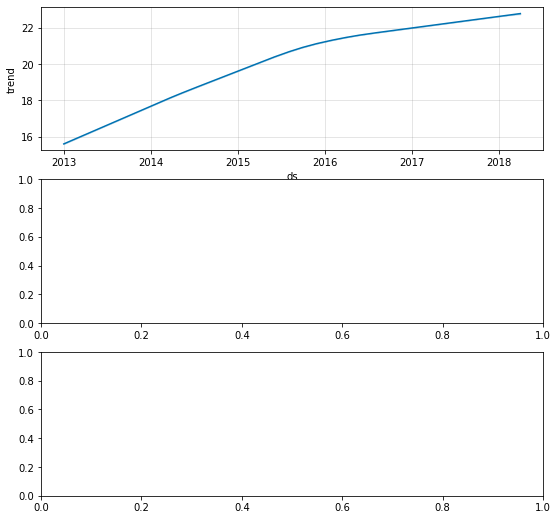

In [0]:
trends_fig = model.plot_components(forecast_pd)
display(trends_fig)

And here, we can see how our actual and predicted data line up as well as a forecast for the future, though we will limit our graph to the last year of historical data just to keep it readable:

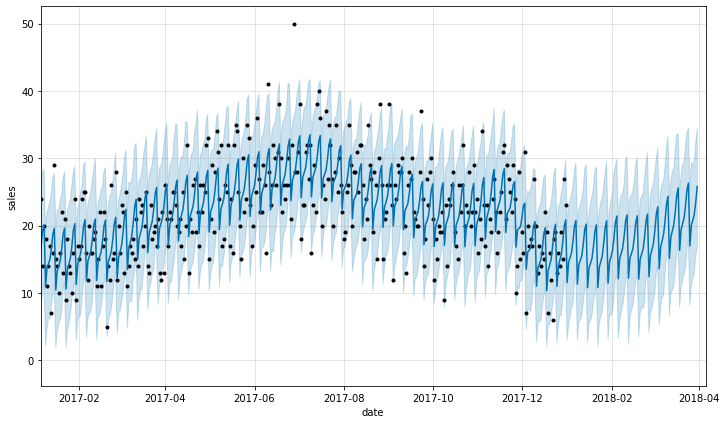

In [0]:
predict_fig = model.plot( forecast_pd, xlabel='date', ylabel='sales')

# adjust figure to display dates from last year + the 90 day forecast
xlim = predict_fig.axes[0].get_xlim()
new_xlim = ( xlim[1]-(180.0+365.0), xlim[1]-90.0)
predict_fig.axes[0].set_xlim(new_xlim)

display(predict_fig)

**NOTE** This visualization is a bit busy. Bartosz Mikulski provides [an excellent breakdown](https://www.mikulskibartosz.name/prophet-plot-explained/) of it that is well worth checking out.  In a nutshell, the black dots represent our actuals with the darker blue line representing our predictions and the lighter blue band representing our (95%) uncertainty interval.

Visual inspection is useful, but a better way to evaulate the forecast is to calculate Mean Absolute Error, Mean Squared Error and Root Mean Squared Error values for the predicted relative to the actual values in our set:

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from datetime import date
import pandas as pd

# get historical actuals & predictions for comparison
actuals_pd = history_pd[ history_pd['ds'] < date(2018, 1, 1) ]['y']
#predicted_pd = forecast_pd[ forecast_pd['ds'] < date(2018, 1, 1) ]['yhat']
predicted_pd = forecast_pd[ forecast_pd['ds'] < pd.Timestamp(2018, 1, 1) ]['yhat']

# calculate evaluation metrics
mae = mean_absolute_error(actuals_pd, predicted_pd)
mse = mean_squared_error(actuals_pd, predicted_pd)
rmse = sqrt(mse)

# print metrics to the screen
print( '\n'.join(['MAE: {0}', 'MSE: {1}', 'RMSE: {2}']).format(mae, mse, rmse) )

MAE: 3.4866179918344833
MSE: 19.388852229285717
RMSE: 4.40327744177967

FBProphet provides [additional means](https://facebook.github.io/prophet/docs/diagnostics.html) for evaluating how your forecasts hold up over time. You're strongly encouraged to consider using these and those additional techniques when building your forecast models but we'll skip this here to focus on the scaling challenge.

###Scaling Model Training & Forecasting

With the mechanics under our belt, let's now tackle our original goal of building numerous, fine-grain models & forecasts for individual store and item combinations.  We will start by assembling sales data at the store-item-date level of granularity:

**NOTE**: The data in this data set should already be aggregated at this level of granularity but we are explicitly aggregating to ensure we have the expected data structure.

In [0]:
sql_statement = '''
  SELECT
    store,
    item,
    CAST(date as date) as ds,
    SUM(sales) as y
  FROM train
  GROUP BY store, item, ds
  ORDER BY store, item, ds
  '''

store_item_history = (
  spark
    .sql( sql_statement )
    .repartition(sc.defaultParallelism, ['store', 'item'])
  ).cache()

With our data aggregated at the store-item-date level, we need to consider how we will pass our data to FBProphet. If our goal is to build a model for each store and item combination, we will need to pass in a store-item subset from the dataset we just assembled, train a model on that subset, and receive a store-item forecast back. We'd expect that forecast to be returned as a dataset with a structure like this where we retain the store and item identifiers for which the forecast was assembled and we limit the output to just the relevant subset of fields generated by the Prophet model:

In [0]:
from pyspark.sql.types import *

result_schema =StructType([
  StructField('ds',DateType()),
  StructField('store',IntegerType()),
  StructField('item',IntegerType()),
  StructField('y',FloatType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

To train the model and generate a forecast we will leverage a Pandas user-defined function (UDF).  We will define this function to receive a subset of data organized around a store and item combination.  It will return a forecast in the format identified in the previous cell:

In [0]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_store_item( history_pd ):
  
  # TRAIN MODEL AS BEFORE
  # --------------------------------------
  # remove missing values (more likely at day-store-item level)
  history_pd = history_pd.dropna()
  
  # configure the model
  model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
    )
  
  # train the model
  model.fit( history_pd )
  # --------------------------------------
  
  # BUILD FORECAST AS BEFORE
  # --------------------------------------
  # make predictions
  future_pd = model.make_future_dataframe(
    periods=90, 
    freq='d', 
    include_history=True
    )
  forecast_pd = model.predict( future_pd )  
  # --------------------------------------
  
  # ASSEMBLE EXPECTED RESULT SET
  # --------------------------------------
  # get relevant fields from forecast
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  # get relevant fields from history
  h_pd = history_pd[['ds','store','item','y']].set_index('ds')
  
  # join history and forecast
  results_pd = f_pd.join( h_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)
  
  # get store & item from incoming data set
  results_pd['store'] = history_pd['store'].iloc[0]
  results_pd['item'] = history_pd['item'].iloc[0]
  # --------------------------------------
  
  # return expected dataset
  return results_pd[ ['ds', 'store', 'item', 'y', 'yhat', 'yhat_upper', 'yhat_lower'] ]  

There's a lot taking place within our UDF, but if you compare the first two blocks of code within which the model is being trained and a forecast is being built to the cells in the previous portion of this notebook, you'll see the code is pretty much the same as before. It's only in the assembly of the required result set that truly new code is being introduced and it consists of fairly standard Pandas dataframe manipulations.

Now let's call our UDF to build our forecasts.  We do this by grouping our historical dataset around store and item.  We then apply our UDF to each group and tack on today's date as our *training_date* for data management purposes:

In [0]:
from pyspark.sql.functions import current_date

results = (
  store_item_history
    .groupBy('store', 'item')
    .apply(forecast_store_item)
    .withColumn('training_date', current_date() )
    )

results.createOrReplaceTempView('new_forecasts')

/databricks/spark/python/pyspark/sql/pandas/group_ops.py:76: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
 "more details.", UserWarning)

We we are likely wanting to report on our forecasts, so let's save them to a queriable table structure:

In [0]:
%sql
-- create forecast table
create table if not exists forecasts (
  date date,
  store integer,
  item integer,
  sales float,
  sales_predicted float,
  sales_predicted_upper float,
  sales_predicted_lower float,
  training_date date
  )
using delta
partitioned by (training_date);

-- load data to it
insert into forecasts
select 
  ds as date,
  store,
  item,
  y as sales,
  yhat as sales_predicted,
  yhat_upper as sales_predicted_upper,
  yhat_lower as sales_predicted_lower,
  training_date
from new_forecasts;

But how good (or bad) is each forecast?  Using the UDF technique, we can generate evaluation metrics for each store-item forecast as follows:

In [0]:
import pandas as pd

# schema of expected result set
eval_schema =StructType([
  StructField('training_date', DateType()),
  StructField('store', IntegerType()),
  StructField('item', IntegerType()),
  StructField('mae', FloatType()),
  StructField('mse', FloatType()),
  StructField('rmse', FloatType())
  ])

# define udf to calculate metrics
@pandas_udf( eval_schema, PandasUDFType.GROUPED_MAP )
def evaluate_forecast( evaluation_pd ):
  
  # get store & item in incoming data set
  training_date = evaluation_pd['training_date'].iloc[0]
  store = evaluation_pd['store'].iloc[0]
  item = evaluation_pd['item'].iloc[0]
  
  # calulate evaluation metrics
  mae = mean_absolute_error( evaluation_pd['y'], evaluation_pd['yhat'] )
  mse = mean_squared_error( evaluation_pd['y'], evaluation_pd['yhat'] )
  rmse = sqrt( mse )
  
  # assemble result set
  results = {'training_date':[training_date], 'store':[store], 'item':[item], 'mae':[mae], 'mse':[mse], 'rmse':[rmse]}
  return pd.DataFrame.from_dict( results )

# calculate metrics
results = (
  spark
    .table('new_forecasts')
    .filter('ds < \'2018-01-01\'') # limit evaluation to periods where we have historical data
    .select('training_date', 'store', 'item', 'y', 'yhat')
    .groupBy('training_date', 'store', 'item')
    .apply(evaluate_forecast)
    )
results.createOrReplaceTempView('new_forecast_evals')

Once again, we will likely want to report the metrics for each forecast, so we persist these to a queriable table:

In [0]:
%sql

create table if not exists forecast_evals (
  store integer,
  item integer,
  mae float,
  mse float,
  rmse float,
  training_date date
  )
using delta
partitioned by (training_date);

insert into forecast_evals
select
  store,
  item,
  mae,
  mse,
  rmse,
  training_date
from new_forecast_evals;

We now have constructed a forecast for each store-item combination and generated basic evaluation metrics for each.  To see this forecast data, we can issue a simple query (limited here to product 1 across stores 1 through 10):

In [0]:
%sql

SELECT
  store,
  date,
  sales_predicted,
  sales_predicted_upper,
  sales_predicted_lower
FROM forecasts a
WHERE item = 1 AND
      --store IN (1, 2, 3, 4, 5) AND
      date >= '2018-01-01' AND
      training_date=current_date()
ORDER BY store

store,date,sales_predicted,sales_predicted_upper,sales_predicted_lower
1,2018-01-01,11.55856,19.253052,3.4828331
1,2018-01-02,14.581306,22.971064,6.094915
1,2018-01-03,15.255412,24.280428,6.4044094
1,2018-01-04,15.998461,25.594143,7.745382
1,2018-01-05,17.707659,26.670391,9.160573
1,2018-01-06,19.916822,28.345634,10.759525
1,2018-01-07,20.769077,29.779951,11.2698555
1,2018-01-08,11.338236,19.121284,2.8116171
1,2018-01-09,14.265854,22.914446,5.202219
1,2018-01-10,14.85803,23.430637,6.2970366


And for each of these, we can retrieve a measure of help us assess the reliability of each forecast:

In [0]:
%sql

SELECT
  store,
  mae,
  mse,
  rmse
FROM forecast_evals a
WHERE item = 1 AND
      training_date=current_date()
ORDER BY store

store,mae,mse,rmse
1,3.486618,19.388851,4.4032774
2,4.2349987,27.934935,5.285351
3,3.9919455,25.205715,5.0205293
4,3.8167577,23.144802,4.8109045
5,3.2819884,17.394875,4.1707163
6,3.2116706,16.175964,4.0219355
7,3.0865371,15.5900545,3.9484243
8,4.307374,30.42084,5.515509
9,3.8267696,23.397345,4.83708
10,3.955878,25.307745,5.03068
